# Open Ocean
# Open Earth Fundation

<h1> Step 2: calculate different metrics for each modulating factor </h1>
    
This notebook is the second part of the Step1_Curate_IUCN_RedList.ipynb

<h2> Modulating Factor 5: Habitats' Survey  </h2>

Marine ecosystems are home to a host of different species ranging from planktonic organisms that form the base of the marine food web to large marine mammals. Many species rely on marine ecosystems for both food and shelter from predators. So, a place with more habitat types has a high marine biodiversity value.

From the [IUCN Global Ecosystem Typology 2.0](https://portals.iucn.org/library/sites/library/files/documents/2020-037-En.pdf) it has that the marine global realms have 3 biomes (components of a core or transitional realm united by one or a few common major ecological drivers that regulate major ecological functions):
- M1: Marine shelf biome
- M2: Pelagic ocean waters biome
- M3: Deep sea floors biome

The purpose of this notebook is count the number of Ecosystem Functional Groups (EFG) in ACMC.

### Data sources
The data needed for this project is available in the Ocean Program S3 Bucket in the following directions:

This folder contains the layers needed to calculate the number of ecosystems in a grid:
- IUCN Marine Ecosystem Typology: https://ocean-program.s3.amazonaws.com/data/raw/Ecosystems/

Our Marine Protected Area of interest -> ACMC polygon: https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson

**In point 2 you can find a way to access this data**

### 1. Importing packages and libraries

In [1]:
# load basic libraries
import os
import glob
import boto3

import math
import numpy as np
import pandas as pd

# to plot
import matplotlib.pyplot as plt

# to manage shapefiles
import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box

In [2]:
import fiona; #help(fiona.open)

In [3]:
%load_ext autoreload

In [4]:
#Run this to reload the python file
%autoreload 2
from marinebiodiversity_utils import *

### 2. Accessing the data

**EFG layers**

The size of these layers is ~1.0 GB, sometimes try to access it from the public AWS S3 bucket 'directly' can be time consuming.

Two options:
1. Have patience and run it anyway
2. Download the file in your computer and read it locally

**Option 1**

In [18]:
#To list the paths and names of the Ecosystem Functional Groups (EFG) files from AWS S3 bucket:

s3 = boto3.resource('s3')
bucket = s3.Bucket('ocean-program')

eco_names = []

for obj in bucket.objects.filter(Prefix='data/raw/Ecosystems/'):
    name = obj.key[:]
    eco_names.append(f'https://ocean-program.s3.amazonaws.com/{name}')

**Option 2**

In [ ]:
# Initialize S3 client
s3 = boto3.client('s3')

# Set the name of the bucket and the path to the directory
bucket_name = 'ocean-program'
directory_path = 'data/raw/Ecosystems/'

# List all files in the directory
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=directory_path)

# Download each file
for obj in response['Contents']:
    # Skip directories
    if obj['Key'].endswith('/'):
        continue
    
    # Download the file
    file_name = obj['Key'].split('/')[-1]
    s3.download_file(ocean-program, obj['Key'], file_name)
    print(f"Downloaded file: {file_name}")

The downloaded files will be saved in the current working directory, so to list it:

In [ ]:
source_dir = './'
eco_names = np.sort(glob.glob(source_dir + "/*.json"))

**Import the entire marine protected area**

ACMC is the acronyms for the entire conservation area: Cocos Marine Conservation Area

In [11]:
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [12]:
ACMC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 3. Data analysis

1. Making a geoDataFrame with all geometries within ACMC

In [13]:
%%time
joined = Clip_EFG(eco_names, ACMC, 4326)

CPU times: user 3min 45s, sys: 8.95 s, total: 3min 54s
Wall time: 8min 18s


**Plot of the geometries in ACMC**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


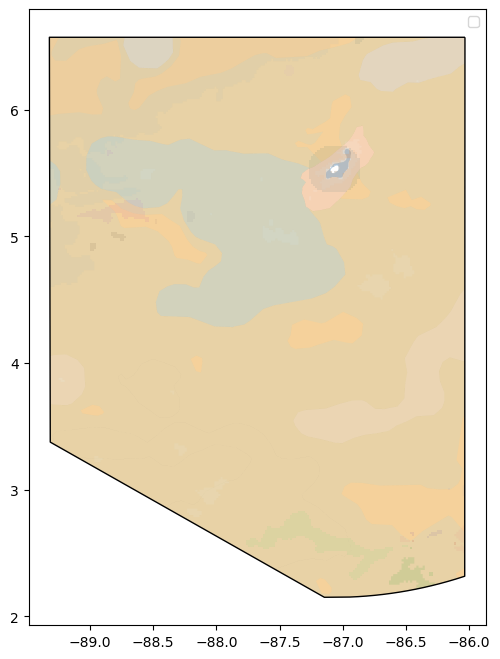

In [16]:
fig, ax = plt.subplots(figsize = (8,8))

ax.set_aspect('equal')

joined.plot(ax=ax, alpha = 0.15, cmap = 'tab20', edgecolor = 'grey', linewidth = 0.01)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')

plt.legend()
plt.show();

2. Counting the overlapping geometries

In [15]:
overlap_geo = count_overlapping_geometries(joined)

/Users/maureenfonseca/Desktop/Oceans/oceanprogram/Marine_Ecosystem_Credtis/Marine_Biodiversity/MBU_Methodology/marinebiodiversity_utils.py:195: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Desktop/Oceans/oceanprogram/Marine_Ecosystem_Credtis/Marine_Biodiversity/MBU_Methodology/marinebiodiversity_utils.py:216: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


Making grids

In [24]:
hexagon = create_grid(ACMC, "hexagon", 0.05, 4326)

Obtaining the maximum number of habitats in a grid

In [28]:
#This is to count how many ecosystems are in each grid 
merged2 = gpd.sjoin(overlap_geo, hexagon, how='left')

merged2['n_habitats']= overlap_geo['count_intersections']

# Compute stats per grid cell
dissolve = merged2.dissolve(by="index_right")#, aggfunc="count")

# put this into cell
hexagon.loc[dissolve.index, 'n_habitats'] = dissolve.n_habitats.values

### 4. Plot each grid color-coded to the number of habitats contained within it

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


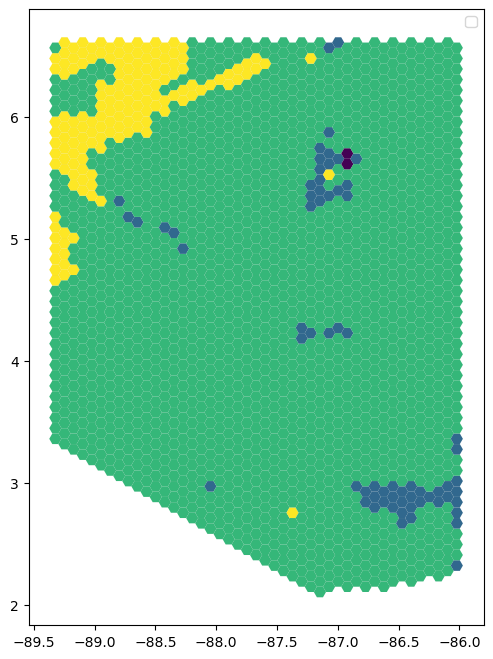

In [29]:
fig, ax = plt.subplots(figsize = (8,8))

ax.set_aspect('equal')
hexagon.plot(ax = ax, column = 'n_habitats', cmap = 'viridis', edgecolor = 'grey', linewidth = 0.01)

plt.legend()
plt.show()

### 5. Calculation of Marine Biodiversity Units (MBUs)

**Formula**

total MBUs = $\text{Normalization Factor}\times \text{Total Area x Number} (\text{ km}^2) \times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} $

In [32]:
def MBU_HS(local_value, value_to_normalize):
    
    normalized_fact = local_value / value_to_normalize
    
    #Selection of local number of habitats
    new_hexagon = hexagon[hexagon['n_habitats'] == int(local_value)]
    
    #Area in sqkms
    #crs=5367 description -> https://epsg.io/5367
    total_area = np.sum(new_hexagon.to_crs(crs=5367).geometry.area*10**(-6))
    
    #Total MBUs
    MBUs = normalized_fact * total_area
    
    return MBUs

**Assumption 1: Global Normalization**

From the [IUCN Global Ecosystem Typology 2.0](https://portals.iucn.org/library/sites/library/files/documents/2020-037-En.pdf) it has that the marine global realms have 3 biomes (components of a core or transitional realm united by one or a few common major ecological drivers that regulate major ecological functions):
- M1: Marine shelf biome (9)
- M2: Pelagic ocean waters biome (5)
- M3: Deep sea floors biome (7)

TOTAL: 21 Ecosystem Functional Groups

Note: The number in () is the number of Ecosystem Functional Groups (EFG) within the biomes

So, the idea here is to have a `normalized global factor`, which means we are comparing the total number of ecosystem functional groups per square kilometer in ACMC to the total number of ecosystem functional groups in the global marine realms.

Normalization factor $ = \frac{\text{Total number of EFG in ACMC } \text{ (local value)}}{\text{Total number of EFG globally} \text{ (max global value)}}) $

total MBUs = $\text{Normalization Factor}\times \text{Total Area x Number} (\text{ km}^2) \times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} $

In [37]:
sum_g = []
for x in range(1,8):
    
    MBU = int(MBU_HS(x,21))
    print('If the number of habitats is '+str(x))
    print('The number of MBUs is: '+str(MBU))
    print('---------------------------------------')
    
    sum_g.append(MBU)
    
print('The total number of MBUs for ACMC is: '+ str(np.sum(sum_g)))

If the number of habitats is 1
The number of MBUs is: 0
---------------------------------------
If the number of habitats is 2
The number of MBUs is: 0
---------------------------------------
If the number of habitats is 3
The number of MBUs is: 22
---------------------------------------
If the number of habitats is 4
The number of MBUs is: 1020
---------------------------------------
If the number of habitats is 5
The number of MBUs is: 36478
---------------------------------------
If the number of habitats is 6
The number of MBUs is: 3522
---------------------------------------
If the number of habitats is 7
The number of MBUs is: 0
---------------------------------------
The total number of MBUs for ACMC is: 41042


`Issues with this assumption:`

To a global normalization, we need to know the maximun global number that we can find in a grid, it isn't the total number of EFG in the global marine realms

To solve this:

- We are doing some sampling test with different methodologies to find that global value to normalize. 

You can review our first test here:

((add link for the notebook))

**Assumption 2: Local Normalization**

Now, instead of counting globally, we're going to count locally. This means that in ACMC there are:
- M1: Marine shelf biome (5)
- M2: Pelagic ocean waters biome (4)
- M3: Deep sea floors biome (4)

TOTAL: 13 EFG

Note: This information was obtained by overlaying each global EFG layer with the ACMC polygon.

In [36]:
sum_l = []
for x in range(1,8):
    
    MBU = int(MBU_HS(x,13))
    print('If the number of habitats is '+str(x))
    print('The number of MBUs is: '+str(MBU))
    print('---------------------------------------')
    
    sum_l.append(MBU)
    
print('The total number of MBUs for ACMC is: '+ str(np.sum(sum_l)))

If the number of habitats is 1
The number of MBUs is: 0
---------------------------------------
If the number of habitats is 2
The number of MBUs is: 0
---------------------------------------
If the number of habitats is 3
The number of MBUs is: 36
---------------------------------------
If the number of habitats is 4
The number of MBUs is: 1647
---------------------------------------
If the number of habitats is 5
The number of MBUs is: 58926
---------------------------------------
If the number of habitats is 6
The number of MBUs is: 5690
---------------------------------------
If the number of habitats is 7
The number of MBUs is: 0
---------------------------------------
The total number of MBUs for ACMC is: 66299


`Issues with this assumption:`

To a local normalization, we need to know the maximun local number that we can find in a grid, it isn't the total number of EFG of global marine realms in that place

**Assumption 3: Sqkm Normalization**

Finally, we are considering the maximum value found in a sqkm in ACMC to normalize.

TOTAL: 6 EFG

In [38]:
sum_s = []
for x in range(1,7):
    
    MBU = int(MBU_HS(x,6))
    print('If the number of habitats is '+str(x))
    print('The number of MBUs is: '+str(MBU))
    print('---------------------------------------')
    
    sum_s.append(MBU)
    
print('The total number of MBUs for ACMC is: '+ str(np.sum(sum_s)))

If the number of habitats is 1
The number of MBUs is: 0
---------------------------------------
If the number of habitats is 2
The number of MBUs is: 0
---------------------------------------
If the number of habitats is 3
The number of MBUs is: 79
---------------------------------------
If the number of habitats is 4
The number of MBUs is: 3570
---------------------------------------
If the number of habitats is 5
The number of MBUs is: 127673
---------------------------------------
If the number of habitats is 6
The number of MBUs is: 12328
---------------------------------------
The total number of MBUs for ACMC is: 143650


`Issues with this assumption:`

Here, we are applying a specific local normalization (ACMC normalization) because the maximum value in a grid in the Costa Rican EEZ is not considered, it is only for ACMC.

**Next Step:**

[x] Discuss with the team about these different assumptions

Obtain a global normalization is a hard thing. So, the next step is make different sampling methodologies to search the maximun statistical number of habitats in a sqkm around the world

[ ] 1. Random sampling

[x] 2. MPA comparison sampling (started!)